In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import torch

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

from fastai.vision import *
from fastai.metrics import accuracy, Precision, Recall, FBeta
from fastai.callbacks.csv_logger import CSVLogger
from fastai.callbacks.tracker import SaveModelCallback

In [3]:
os.chdir(os.pardir)

In [4]:
from src.configs.constants import (
    CLASS_COL, IMG_COL,
    TRAIN_DF_NAME, TEST_DF_NAME,
    DATA_DIR, SAVED_DIR, WEIGHTS_FOLDER, CSV_FOLDER, TEST_FOLDER, TRAIN_FOLDER
)
from src.dataloaders.preprocess import get_indices_split

In [5]:
EXP_NAME = 'resnet50'

IMG_SIZE = 224
BATCH_SIZE = 32

# Loading Data

Visit **data block** API.

In [6]:
df = pd.read_csv(os.path.join(DATA_DIR, TRAIN_DF_NAME))
df.head()

,img_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,Ford F-450 Super Duty Crew Cab 2012


## Train/Val/Test Splits

DataBunch does the split for us.  
Consider **Stratified Split**?

In [7]:
train_idx, val_idx = get_indices_split(df, CLASS_COL, 0.2)
# 
# val_df = training_df.iloc[val_indices]
# train_df = training_df.iloc[train_indices]
# 
# print(f'Train Size: {len(train_df)}')
# print(f'Val Size: {len(val_df)}')

## Define Augmentations

Possibly too much cropping.

In [8]:
tfms = get_transforms()

## Loading Model

In [179]:
from pretrainedmodels import inceptionv4
model = inceptionv4(num_classes=1000, pretrained='imagenet')

In [180]:
model_stats = [model.mean, model.std]

In [184]:
img_size = model.input_size[1]

## Create DataBunch

In [9]:
# Set random seed for validation split
# np.random.seed(42)

# data = ImageDataBunch.from_csv(
#     DATA_DIR,
#     folder='train',
#     csv_labels='train_labels.csv',
#     valid_pct=0.2,
#     fn_col=IMG_COL,
#     label_col=CLASS_COL,
#     ds_tfms=tfms,
#     size=IMG_SIZE,
#     bs=BATCH_SIZE
# )\
#     .normalize(imagenet_stats)

In [183]:
src = (ImageList
    .from_csv(path=DATA_DIR,
              csv_name=TRAIN_DF_NAME,
              folder=TRAIN_FOLDER,
              cols=IMG_COL)
    # stratified split
    .split_by_idxs(train_idx, val_idx)
    .label_from_df(CLASS_COL))

In [10]:
src

LabelLists;

Train: LabelList (6515 items)
x: ImageList
Image (3, 1600, 2405),Image (3, 524, 698),Image (3, 768, 1024),Image (3, 480, 640),Image (3, 480, 640)
y: CategoryList
AM General Hummer SUV 2000,Lamborghini Diablo Coupe 2001,Hyundai Tucson SUV 2012,GMC Terrain SUV 2012,Ford Focus Sedan 2007
Path: data;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 480, 640),Image (3, 528, 792),Image (3, 1200, 1600),Image (3, 200, 600),Image (3, 400, 600)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: data;

Test: None

In [191]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=BATCH_SIZE)
        .normalize(imagenet_stats))

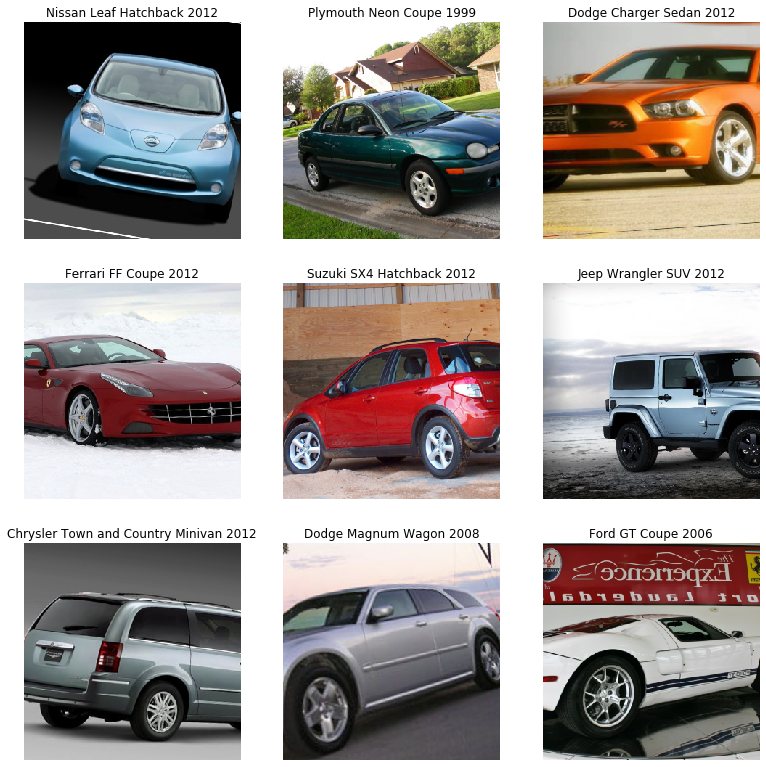

In [186]:
data.show_batch(rows=3, figsize=(11,11))

In [ ]:
len(data.classes),data.c

In [ ]:
data.train_ds

In [12]:
data.valid_ds

LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: /floyd/input/data

In [ ]:
data.train_ds.x[1]

In [ ]:
data.valid_ds.y[0]

In [ ]:
np.array(data.valid_ds.y)

# Training

## Define Metrics

In [13]:
# precision = Precision('micro')
# recall = Recall('micro')
# fbeta = FBeta('micro')

In [153]:
metrics = [accuracy]

## Define Learner

In [173]:
from src.models.model_configs import resnet50_config

In [174]:
learn = cnn_learner(
    data,
    metrics=metrics, 
    path=SAVED_DIR,
    model_dir=WEIGHTS_FOLDER,
    **resnet50_config
)

In [177]:
learn.load('resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (6515 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
AM General Hummer SUV 2000,Lamborghini Diablo Coupe 2001,Hyundai Tucson SUV 2012,GMC Terrain SUV 2012,Ford Focus Sedan 2007
Path: data;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Ford Ranger SuperCab 2011,Toyota 4Runner SUV 2012,Aston Martin V8 Vantage Convertible 2012,Suzuki SX4 Sedan 2012,Audi RS 4 Convertible 2008
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0):

## Define Callbacks

In [16]:
csv_logger = CSVLogger(
    learn,
    append=True,
    filename=os.path.join(CSV_FOLDER, EXP_NAME)
)

save_model_cb = SaveModelCallback(
    learn,
    # Also loads best model at the end of training
    every='improvement',
    name=EXP_NAME
)

In [17]:
callbacks = [csv_logger, save_model_cb]

## Stage-1

**Transfer learning**; only train the classifier head first.

Find the learning rate that results in a steep decrease in the network's loss;  
the part of the **steepest downward slope** (not the bottom), before the loss shoots up.

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-03


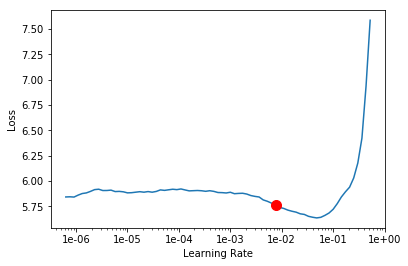

In [19]:
# Indicates the point where the gradient is the steepest
learn.recorder.plot(suggestion=True)

In [ ]:
learn.recorder.min_grad_lr

In [26]:
torch.cuda.empty_cache()

In [18]:
learn.fit_one_cycle(
    2, 
    max_lr=1e-2, 
    callbacks=callbacks
)

epoch,train_loss,valid_loss,accuracy,time
0,4.385000,3.533988,0.187845,02:45
1,2.863825,2.226642,0.443831,02:35


Better model found at epoch 0 with val_loss value: 3.533987522125244.
Better model found at epoch 1 with val_loss value: 2.226642370223999.


In [28]:
learn.save('stage-1')

## Stage 2

**Fine-tuning**; unfreeze all layers and train, but with discriminative layer training.

In [ ]:
learn.unfreeze()

**Discriminative layer training**
- Slower for earlier layers, faster for later layers, i.e. slice(start, end)
- 'start' should be inferred from the learning rate finder
    - At the bottom-ish, just before it shoots up, but 10x smaller.
- 'end' should be x5/10 smaller than lr used in Stage 1.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

In [ ]:
learn.save('stage-2')

In [ ]:
learn.recorder.plot_losses()

## Stage 3: Increasing Image Size?

Perform transfer learning with the already pretrained model with smaller image sizes.

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

In [ ]:
learn.freeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

## Export Model

In [19]:
learn.export(f'{EXP_NAME}.pkl')

# Evaluation

## Plotting stuffss

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15, 11))

In [ ]:
# interp.plot_confusion_matrix(figsize=(12, 12))

In [ ]:
interp.most_confused(min_val=2)

## Evaluation on Test Set

When evaluating test set, should go through the same transformations and normalization.

As specified by the competition, the model must output a confidence score for every classification.

from csv

In [23]:
test_imgs = ImageList.from_csv(
                path=DATA_DIR,
                folder=TEST_FOLDER,
                csv_name=TEST_DF_NAME,
                cols=IMG_COL)

from folder (without labels)

In [43]:
test_imgs = ImageList.from_folder(
    path=os.path.join(DATA_DIR, TEST_FOLDER),
)

In [41]:
len(test_imgs.items)

8041

In [56]:
learn = load_learner(
    SAVED_DIR,
    f'{EXP_NAME}.pkl',
    test=test_imgs
)

save list of classes

**Wrong Order of Images**

In [19]:
test_df = pd.read_csv(os.path.join(DATA_DIR, TEST_DF_NAME))
test_df.head()

,img_name,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,30,52,246,147,Suzuki Aerio Sedan 2007
1,00002.jpg,100,19,576,203,Ferrari 458 Italia Convertible 2012
2,00003.jpg,51,105,968,659,Jeep Patriot SUV 2012
3,00004.jpg,67,84,581,407,Toyota Camry Sedan 2012
4,00005.jpg,140,151,593,339,Tesla Model S Sedan 2012


In [20]:
print(len(test_df))

8041


In [21]:
y_true = test_df[CLASS_COL].values

In [22]:
y_true = [learn.data.classes.index(y) for y in y_true]

NameError: name 'learn' is not defined

In [23]:
y_pred, _ = learn.get_preds(ds_type=DatasetType.Test)

In [24]:
y_pred = np.argmax(y_pred, axis=1)

In [25]:
accuracy = accuracy_score(y_true, y_pred)

In [26]:
accuracy

0.45454545454545453

In [27]:
precision, recall, fscore, _ = \
    precision_recall_fscore_support(y_true, y_pred, average='micro')

In [28]:
print(precision, recall, fscore)

0.45454545454545453 0.45454545454545453 0.45454545454545453


## Prediction

In [57]:
# Read in test data images
test_imgs = ImageList.from_folder(
    path=os.path.join(DATA_DIR, TEST_FOLDER),
)

In [58]:
# load learner, and attach test set to it
learn = load_learner(
    SAVED_DIR,
    f'{EXP_NAME}.pkl',
    test=test_imgs
)

In [127]:
len(learn.data.test_ds)

8041

In [129]:
len(learn.data.classes)

196

In [143]:
overall_preds = np.zeros((8041, 196))

In [150]:
overall_preds += np.array(preds)

In [151]:
overall_preds / 3 == np.array(preds)

array([[ True,  True,  True,  True, ...,  True,  True,  True,  True],
       [ True,  True,  True,  True, ...,  True,  True,  True,  True],
       [ True,  True,  True,  True, ...,  True,  True,  True,  True],
       [ True,  True,  True,  True, ...,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True, ...,  True,  True,  True,  True],
       [ True,  True,  True,  True, ...,  True,  True,  True,  True],
       [ True,  True,  True,  True, ...,  True,  True,  True,  True],
       [ True,  True,  True,  True, ...,  True,  True,  True,  True]])

In [61]:
# Retrieve classes
classes = learn.data.classes

In [63]:
# Get predictions
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [65]:
preds.shape

torch.Size([8041, 196])

In [106]:
# Initialize dataframe with the predictions
df = pd.DataFrame(np.array(preds), columns=classes)
df.head()

,AM General Hummer SUV 2000,Acura Integra Type R 2001,Acura RL Sedan 2012,Acura TL Sedan 2012,Acura TL Type-S 2008,Acura TSX Sedan 2012,Acura ZDX Hatchback 2012,Aston Martin V8 Vantage Convertible 2012,Aston Martin V8 Vantage Coupe 2012,Aston Martin Virage Convertible 2012,...,Toyota Camry Sedan 2012,Toyota Corolla Sedan 2012,Toyota Sequoia SUV 2012,Volkswagen Beetle Hatchback 2012,Volkswagen Golf Hatchback 1991,Volkswagen Golf Hatchback 2012,Volvo 240 Sedan 1993,Volvo C30 Hatchback 2012,Volvo XC90 SUV 2007,smart fortwo Convertible 2012
0,4.351335e-10,1.251062e-05,1.284656e-05,1.920555e-07,2.101795e-05,3.319944e-03,7.749030e-11,3.239688e-10,1.580783e-08,1.413226e-11,...,2.733461e-06,1.791327e-02,5.779148e-06,9.475239e-08,2.659586e-08,1.001191e-04,2.252568e-08,3.725076e-06,4.798918e-07,2.184875e-09
1,2.355673e-08,7.758303e-05,2.565207e-08,5.618625e-07,1.498278e-07,1.628974e-06,1.617010e-07,2.177355e-03,5.665701e-05,1.437490e-04,...,5.844518e-05,9.035356e-07,1.656469e-08,3.804403e-07,5.809207e-06,7.047552e-08,1.960322e-06,2.676482e-04,9.677183e-09,3.241985e-07
2,2.181083e-07,1.610692e-14,1.136734e-17,4.842986e-15,1.977544e-15,7.216689e-15,3.847227e-15,8.715110e-14,6.406419e-17,6.985439e-12,...,1.756606e-14,4.064954e-15,5.395106e-13,1.328577e-12,4.847365e-08,2.327093e-14,8.878903e-10,2.392055e-13,9.590522e-13,1.151380e-13
3,1.534763e-11,3.966667e-12,3.104306e-06,1.063766e-05,2.087037e-07,1.122129e-04,3.637055e-08,1.013245e-11,5.494773e-11,9.964200e-11,...,9.997509e-01,7.158797e-05,8.324235e-09,3.150127e-11,8.072234e-13,4.424781e-09,2.305467e-09,5.627785e-10,3.017688e-15,4.519642e-08
4,2.422756e-06,3.255891e-05,2.872824e-05,1.058075e-06,9.077666e-06,6.279436e-06,6.902306e-07,9.103745e-04,7.199241e-04,7.157468e-05,...,1.512180e-04,1.332874e-04,3.463962e-05,1.397032e-07,2.396173e-07,1.957362e-05,2.913467e-07,1.000980e-04,6.104528e-07,1.051535e-05


In [97]:
df_test.shape

(8041, 196)

In [107]:
# Attach image names to dataframe
img_names = [i.name for i in learn.data.test_ds.items]
df.insert(0, 'img_name', img_names)

In [109]:
df.shape

(8041, 197)

In [117]:
df.to_csv('predictions.csv', index=False)

In [118]:
df = pd.read_csv('predictions.csv')

## Test time augmentation

Take the average of our regular predictions (with weight beta) with the average of predictions obtained through augmented version of the training set (with weight 1-beta).

In [61]:
# Applies prediction using TTA
preds, y = learn.TTA(ds_type=DatasetType.Valid)

KeyboardInterrupt: 

# Log Experiment Information

Calculate validation metrics when training ends.  
Using pandas?

In [58]:
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta
0,0,4.108559,3.278338,0.216697,NaN,0.216697,0.000000
1,epoch,train_loss,valid_loss,accuracy,precision,recall,f_beta
2,0,4.223826,3.344466,0.224064,NaN,0.224064,0.000000


# Cleaning Up

Remove samples that are invalid and don't belong (for entire dataset).  
Able to also look for and remove duplicates.

In [ ]:
# Create new dataset without the split
db = (ImageList.from_folder(path)
               .no_split()
               .label_from_folder()
               .transform(get_transforms(), size=224)
               .databunch())

# And also new learner
learn_cln = cnn_learner(db, models.resnet50, metrics=accuracy)
learn_cln.load('stage-2')

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
from fastai.widget import *

ImageCleaner(ds, idxs, path)

# Deploying

In [ ]:
learn.export()

In [ ]:
learn = load_learner(path)

In [ ]:
img = open_image()

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)

In [ ]:
learn.pred_batch(imgs)